Face detection via ResNet50 & transfer learning:
1. Data preprocessing & augmentation
2. Model training
3. Conversion to a fully convolutional model
4. Heat map generation

Dataset downloaded from: <br>
https://www.cse.msu.edu/computervision/AFLW.zip

Written by:
Amir Avnit <br> amir.avnit@gmail.com



## Initialization

In [1]:
# Import modules

from glob import glob
import os 
import warnings
import numpy as np
import random
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imgaug as ia

import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras import backend as K
from keras.models import Model
from keras.layers.core import Dense,Activation
from keras.layers import Conv2DTranspose,Deconvolution2D, Cropping2D
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from Helper import *
from FullConv import to_fullconv, display_heatmap
from DataGenerator import RandCropBatchGen

Using TensorFlow backend.


In [2]:
# Supress warnings
    
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [3]:
# Set random seed

random_seed=3948296
random.seed(random_seed)

# Data Import & Inspection

In [4]:
TrainPath = 'DataSet/TrainImages/'
TestPath = 'DataSet/TestImages/'
face_files = {}

# Get filenames of train and test sets and Shuffle the order of images.  
face_files['train'] = np.array(glob(TrainPath +'*.jpg'))
random.shuffle(face_files['train'])

# Shuffle order.
face_files['test'] = np.array(glob(TestPath + '*.jpg'))
random.shuffle(face_files['test'])

# Divide training set into training and validation sets.
# Note: since the training set is alreay shuffled, validation images are randomly selected.
valid_perc = 20
valid_nb = np.int(face_files['train'].shape[0]//(100/valid_perc))
face_files['valid'] = face_files['train'][:valid_nb]
face_files['train'] = face_files['train'][valid_nb:]

# Print set sizes.
print('# of train face images: %d' % face_files['train'].shape[0])
print('# of validation face images: %d' % face_files['valid'].shape[0])
print('# of test face images: %d' % face_files['test'].shape[0])

# of train face images: 3121
# of validation face images: 780
# of test face images: 1299


In [5]:
# Get bounding boxes.

BoundingBoxes = loadmat('DataSet/BoundingBox.mat') 

# Assert that sets and bounding box data are of equal sizes.
assert(BoundingBoxes['bboxesTr'].shape[0] == face_files['train'].shape[0]+face_files['valid'].shape[0])
assert(BoundingBoxes['bboxesT'].shape[0] == face_files['test'].shape[0])

In [6]:
# Create a dictionary relating image filepath to bounding box for each set. 

bbox_dict= {}

bbox_dict['train'] = {fname: BoundingBoxes['bboxesTr'][np.int(fname.split('/')[-1].split('.')[0])-1 ].round().astype(int)
              for fname in face_files['train']}

bbox_dict['valid'] = {fname: BoundingBoxes['bboxesTr'][np.int(fname.split('/')[-1].split('.')[0])-1 ].round().astype(int)
              for fname in face_files['valid']}

bbox_dict['test'] = {fname: BoundingBoxes['bboxesT'][np.int(fname.split('/')[-1].split('.')[0])-1 ].round().astype(int)
              for fname in face_files['test']}

## Example Images

train set images:


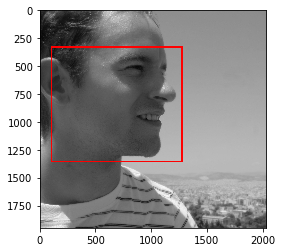

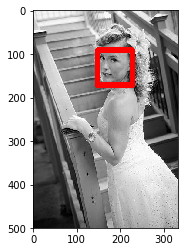

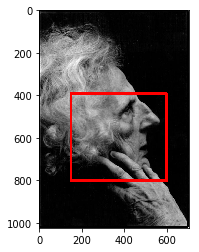

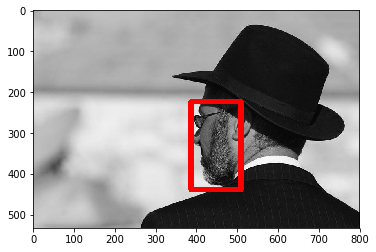

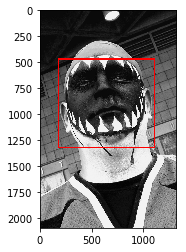

valid set images:


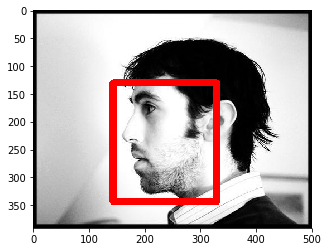

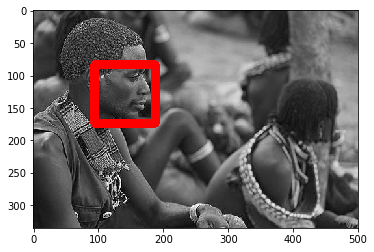

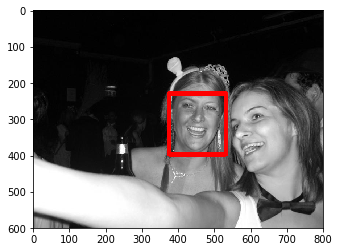

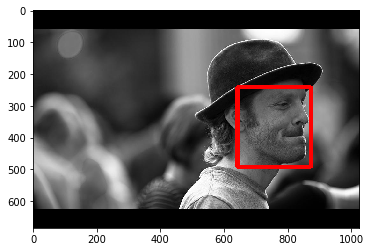

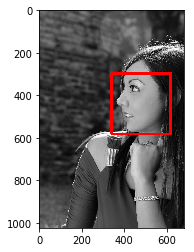

test set images:


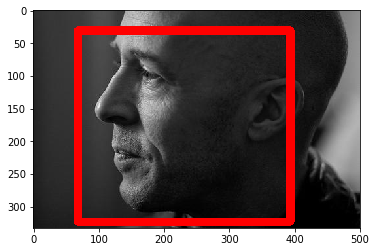

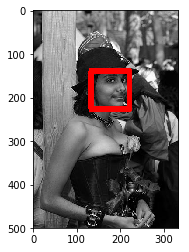

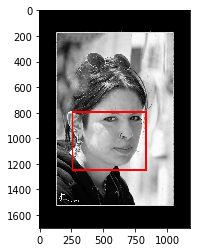

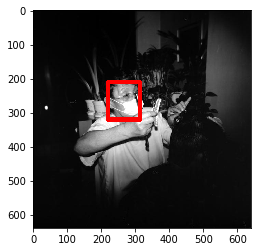

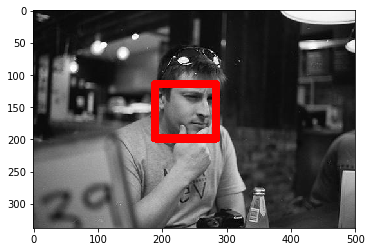

In [7]:
# Present randomly selected images with corresponding bounding boxes.

show_img = 15 # Total number of images to display (to be devided by 3 for each set)
box_width = 12

set_names = ['train','valid','test']

# Randomly choose images to display.
for name in set_names:
    print('{} set images:'.format(name))
    inds = np.random.randint(0,face_files[name].shape[0],show_img//3)
    img_paths = face_files[name][inds] 

    for path in img_paths:
        bbox = bbox_dict[name][path]
        img_disp(path,bbox,box_width)

# Data Preprocessing

## Data Augmentation
Here I create generators to be used for creating training, validation and test samples, 
Augmentation includes random cropping and flipping.

Random sub-windows are randomly sampled and labeled as positive (face) or negative (i.e., non-face) 
if they have 50% of more or 20% or less intersection-over-union (IOU) with the ground truth (i.e., face bounding box), respectively.
Then, each sample has 25% chance to be flipped.

Some of the images contain multiple faces, while only one bounding box is provided for each image. 
Thus, for additional control, cropped samples with 20% or less IOU with the ground truth are labeled as non-face only if no face are detected in them by the provided pre-trained face detector (Haar feature-based cascade classifier) doesn't detect faces in image. 
Alternatively, this multi-face detector can be used to create additional positive samples from images containing more than one face.

In [8]:
# Set random seed for image augmentation
ia.seed(random_seed)

# Set paramateres for augmentation
crop_perc = (.2,.45)    # Crop images from each side by 0 to given percent (randomly chosen)
flip_perc = .25         # Flip images radnomly by a given percent

# Initiate augmenters
crop_aug = ia.augmenters.Crop(percent=crop_perc, keep_size=False, random_state=random_seed)
flip_aug = ia.augmenters.Fliplr(p=flip_perc, random_state=random_seed)

# Extract pretrained Haar feature-based cascade classifier to detect human face
face_cascade = cv2.CascadeClassifier(
    'haarcascades/haarcascade_frontalface_alt.xml')

In [18]:
# Set parameteres for train and validation generators
train_params = {
    'crop_aug': crop_aug,
    'flip_aug': flip_aug,
    'face_cascade': face_cascade,
    'face_files': face_files['train'],
    'bbox_dict': bbox_dict['train'],
    'set_name': 'Training',
    'batch_size': 64,
    'batch_nb': 5,
    'IoU_thresh': (0.2, 0.5),  
    'start_ind': 0,
    'pos_n': 16,  
    'neg_n': 48,  
    'shuffle': True,
    'resize_dim': (224, 224),
    'save_files': False
}

valid_params = {
    'crop_aug': crop_aug,
    'flip_aug': flip_aug,
    'face_cascade': face_cascade,
    'face_files': face_files['valid'],
    'bbox_dict': bbox_dict['valid'],
    'set_name': 'Validation',
    'batch_size': 128, 
    'batch_nb': 1,
    'IoU_thresh': (0.2, 0.5),
    'start_ind': 0,
    'pos_n': 64,
    'neg_n': 64,
    'shuffle': True,
    'resize_dim': (224, 224),
    'save_files': False
}

test_params = {
    'crop_aug': crop_aug,
    'flip_aug': flip_aug,
    'face_cascade': face_cascade,
    'face_files': face_files['test'],
    'bbox_dict': bbox_dict['test'],
    'set_name': 'Test',
    'batch_size': 256, 
    'batch_nb': 1,
    'IoU_thresh': (0.2, 0.5),
    'start_ind': 0,
    'pos_n': 128,
    'neg_n': 128,
    'shuffle': True,
    'resize_dim': (224, 224),
    'save_files': False
}

# Create generators
train_generator = RandCropBatchGen(**train_params)
valid_generator = RandCropBatchGen(**valid_params)
test_generator = RandCropBatchGen(**test_params)

#  Transfer Learning

## Load the Pretrained Network

In [10]:
# Load the ResNet50 model, pretrained on the imagenet dataset

from keras.applications.resnet50 import ResNet50
ResNet50 = ResNet50(weights='imagenet')

## Replace Last Fully-connected (Classificiotn) Layer
The classification problem is binary (i.e., face/non-face). Thus, I replaced the 
last fully-connected layer (which has 1,000 nodes, corresponding to the number of categories in the 
ImageNet dataset) with a two-node layer. I prefered this upon using a one-node layer
(and a sigmoid activation function instead of softmax) since we want to produce heatmaps later.


In [11]:
top_model = Dense(2, activation = 'softmax')(ResNet50.layers[-2].output)

ResNet50 = Model(inputs=ResNet50.input, outputs=top_model, name='dense_new')
ResNet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Train Model

In [6]:
"""
Optional: Generate batches in advance, intead of training via a generator.
"""

# X_train = np.empty((batche_nb,batch_size, 224, 224, 3))
# y_train = np.empty((batche_nb,batch_size), dtype=int)
    
# for i in range(batch_nb):
#     X_train[i],y_train[i] = train_generator.__getitem__(0)

# for batch in range(batch_nb):
#     print("Batch: {}...".format(batch + 1))
#     for epoch in range(epoch_nb):
#         print("   Epoch: {}...".format(epoch + 1))
#         ResNet50.fit(X_train[batch], y_train[batch])
#         validation_data=(valid_tensors, valid_targets),
#         epochs=epochs_nb,
#         callbacks=[checkpointer],
#         verbose=1)

### Set Training Parameters

In [12]:
learning_rate = .001
loss_fun = 'categorical_crossentropy'
metrics = ['accuracy']
optimizer = optimizers.rmsprop(lr=learning_rate)

### Train Model
Here I use fine-tuning by replacing the last fully connected layer and training all network parameters.

In [ ]:
# Set number of epochs, batch size and number of batches to yield from generator for each epoch
epoch_nb = 10
batch_size = 64
steps_per_epoch = 5 

# Compile model
ResNet50.compile(
    optimizer=optimizer, loss=loss_fun, metrics=metrics)

# Save optimal parameters (i.e., of train iteration having the minimal validation loss).
checkpointer = ModelCheckpoint(
    filepath='./Weights/weights.best.ResNet50.hdf5',
    verbose=1,
    save_best_only=True)

# Generate validation set (use same set for each batch, in order to correctly save best weights)
valid_X,valid_y = valid_generator.__getitem__(0)

# Fit model
ResNet50.fit_generator(generator = train_generator,
                      validation_data = (valid_X,valid_y),
                      epochs=epoch_nb,
                      steps_per_epoch = steps_per_epoch,
                      callbacks = [checkpointer],
                      verbose = 1,
                      use_multiprocessing = True,
                      workers = 6,
                      pickle_safe = False, # Use threading instead of multiprocessing to conserve memory
                      max_queue_size = 5)

### Evaluate Model

In [13]:
# Load optimal weights
ResNet50.load_weights('./Weights/weights.best.ResNet50.hdf5')

# Re-compile model
ResNet50.compile(
    optimizer=optimizer, loss=loss_fun, metrics=metrics)

test_score = ResNet50.evaluate_generator(
                   test_generator,
#                    use_multiprocessing = True,
#                    workers = 4,
                   pickle_safe = False,
                   max_queue_size = 5,
                   verbose = 1)

print('Test loss: .{0:.3f}'.format(test_score[0]))
print('Test accuracy: {0:.3f}'.format(test_score[1]))

Test batch #1 ready
1/1 [==============================] - 727s 727s/step
Test loss: .1.983
Test accuracy: 0.625


# Convert to a fully convolutional network
Here I convert the model to a fully convolutional one, which can accept inputs of various sizes
and enable the generation of heatmaps

In [13]:
ResNet50_fconv = to_fullconv(ResNet50)

ResNet50_fconv.summary()

Model cut at layer: 175
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
model_1 (Model)              multiple                  23587712  
_________________________________________________________________
dense_1 (Conv2D)             (None, None, None, 2)     4098      
_________________________________________________________________
activation_50 (Activation)   (None, None, None, 2)     0         
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


# Generate Heatmaps
Here I generate heatmaps from from the fully convolutional network, indicating the importance of 
each location in the image to the face/non-face classification performed by the model.

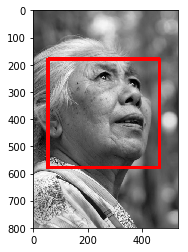

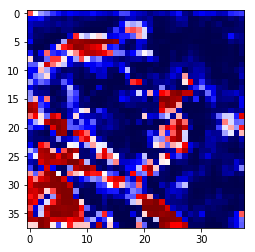

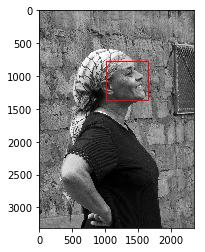

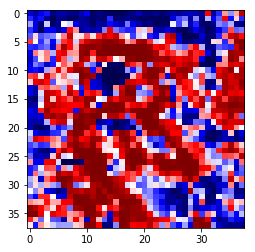

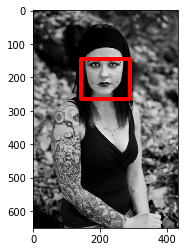

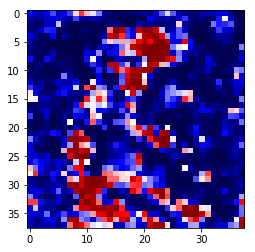

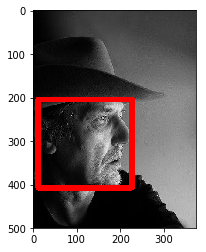

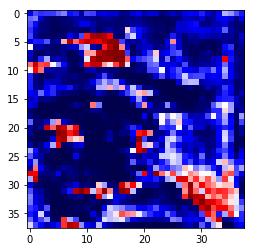

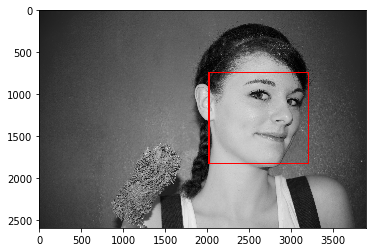

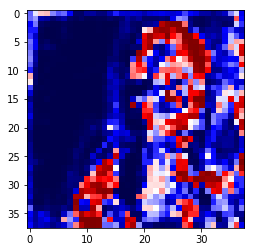

In [15]:
disp_nb = 5

inds = np.random.randint(0,face_files[name].shape[0],disp_nb)
img_paths = face_files['test'][inds] 

for path in img_paths:
    bbox = bbox_dict[name][path]
    img_disp(path,bbox,box_width)

    display_heatmap(ResNet50_fconv, path,0)